# Analysis of Chinese Calligraphy images<a class='tocSkip'>

## Lingxiao Zhou<a class='tocSkip'>

## Introduction

Chinese calligraphy is the writing of Chinese characters as an art form, combining purely visual art and interpretation of the literary meaning.

There are mainly five Chinese script styles. A more detailed explaination can be found [here](https://en.wikipedia.org/wiki/Chinese_script_styles).

- **Seal (Zhuanshu):** It is an ancient style of writing Chinese characters and preserves features of ancient hieroglyphics.


- **Clerical (Lishu):** It Evolved from seal script and  is much more convenient to write than seal script. Clerical script originated from the Qin Dynasty and reached its peak in the Eastern Han Dynasty.


- **Regular (Kaishu):** The script is also called standard script or Zheng Shu. It is the newest of the Chinese script styles, hence most common in modern writings and publications.


- **Semi-cursive (Xingshu):** It derived from clerical script. Because it is not as abbreviated as cursive, most people who can read regular script can read semi-cursive. It is highly useful and also artistic.


- **Cursive (Caoshu):** Cursive script is faster to write than other styles, but difficult to read for those unfamiliar with it. It functions primarily as a kind of shorthand script or calligraphic style.


Each style has its own structure and the way of strokes arrangement. The differences between these styles are subtle and abstract. There are research on the styles recongnition of Chinese calligraphy images. Some deep learning models have achieved high accuracy when classifying calligraphy images. However, the interpretability of these models is limited.


In this project, I want to do some exploratory analysis on Chinese calligraphy images of different styles to extract some meaningful information about the structure and stroke distribution of scripts. The information might be useful in font design. I also want to evaluate the performance of PCA and NMF on Chinese calligraphy images.

## Data Preparation

To make ploting easier, I write a plot function `draw_img`

In [1]:
import matplotlib.pyplot as plt

def draw_img(im, h = 80, w = 80, ax = None):
    """
    takes an image vector and draw the resulting image
    
    input:
        im: image vectcor
        h: height of the image
        w: width of the image
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    ax.imshow(im.reshape(h,w), cmap=plt.cm.gray)
    ax.tick_params(labelbottom=False, labelleft=False)

In this section, I will show how I build the dataset. The dataset is exported to `Chinese_Calligraphy.csv`. You can import the data directly by the following the code and skip this section.

In [2]:
import pandas as pd
df = pd.read_csv ('Chinese_Calligraphy.csv')

### Load some packages

In [2]:
#! pip install openCV-python

import json
import os
import cv2
import sys
import pandas as pd
import numpy as np

### Collecting data


Since the research on the method of image processing based on Chinese calligraphy
is limited, it is difficult to find a good already-made dataset for different calligraphy styles. So I decide to build the dataset by myself. At first, I try to download Calligraphy images through Google images. However, the data I collected in this way is not very good because those images are not properly cropped and there are different numbers of characters in each image. Moreover, characters in some images seem to be horizontally flipped (first and second images in the first row).

<img src="https://1.bp.blogspot.com/-xpWQ4xZzQRU/Xt7zrbyOnnI/AAAAAAAAAQI/OxB-6OYZiJ4mYffuYpLFhwy7GlMZ1-4dwCLcBGAsYHQ/w1684-h1069-p-k-no-nu/try1.PNG" style="width: 800px;" align="center">

I aim to do some exploratory analysis in this project. So I want to use properly cropped images and require that each image only contain one Chinese character. I find a digital Chinese calligraphy collection called [陈忠建字库](http://163.20.160.14/~word/modules/myalbum/index.php). This collection contains about 212,156 single Chinese calligraphy characters written by the calligrapher Zhongjian Chen. I download 6000 images of different styles from the collection. The corresponding labels of those Chinese character images can also be found on the webpage.   Overall, this collection is a good data source. The only problem is that this collection only contains clerical, regular and semi-cursive scripts.  

### Image processing

I use openCV to import the data. The images that I downloaded are gif files, but it seems that openCV does not support gif files. So I change the file extension to jpg.

In [3]:
for i in range(1,121):
    dirName = 'projdata/'+str(i)+'_files/'
    l = os.listdir(dirName)
    for filename in l:
        newname = filename
        newname = newname.split(".")
        
        if newname[-1]=="gif":
            newname[-1]="jpg"
            newname = str.join(".",newname)  
            filename = dirName+filename
            newname = dirName+newname
            os.rename(filename,newname)

I plot some images to make sure that these images are read correctly.

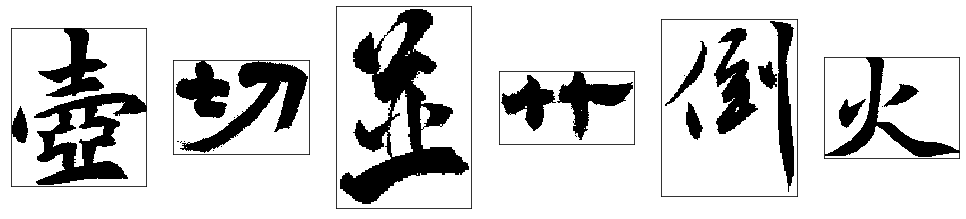

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(17, 4),
                         subplot_kw={'xticks':[], 'yticks':[]})

axes[0].imshow(plt.imread('images/37556.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axes[1].imshow(plt.imread('images/123516.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axes[2].imshow(plt.imread('images/18457.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axes[3].imshow(plt.imread('images/124009.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axes[4].imshow(plt.imread('images/7314.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axes[5].imshow(plt.imread('images/4488.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)


fig.show()

We can see that these images have different sizes. By using OpenCV, I resize these images to 80x80 images without changing their aspect ratios, convert them to grey scale images and inverted black and white colors.

In [5]:
def process_image(img, min_side):
    """
    resize a image to square image with length equal to min_side
    """
    size = img.shape
    h, w = size[0], size[1]
    #recale the image such that the length of longer side is min_side
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    
    # put the image in a blank image with min_side * min_side size
    if new_w % 2 != 0 and new_h % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    elif new_h % 2 != 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    elif new_h % 2 == 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    else:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
 
    pad_img = cv2.copyMakeBorder(resize_img, int(top), int(bottom), int(left), int(right), cv2.BORDER_CONSTANT, value=[255,255,255])
    
    return pad_img

In [7]:
style = []  # record the style of the image
ID = []  # record the filename of the image
for i in range(1,121):
    
    s = ! ls projdata/{i}_files/[0-9]*

    for filename in s:
        try:
            im = plt.imread(filename)
            img_new = process_image(im, 80)
            cv2.imwrite(filename, img_new)
            style.append((i-1)//40)
            ID.append(str(filename).split('/')[2][:-4])
        except:
            #! rm {filename}  # remove images that cannot be identified by imread
            print('cannot open')

cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open
cannot open


In [19]:
tmp  = []
for i in range(1,121):
    
    s = ! ls projdata/{i}_files/[0-9]*
    for filename in s:
        im = plt.imread(filename)
        im = im[:,:,0].flatten()
        tmp.append(im)

df = pd.DataFrame(np.row_stack(tmp))
df = 255-df  # invert colors

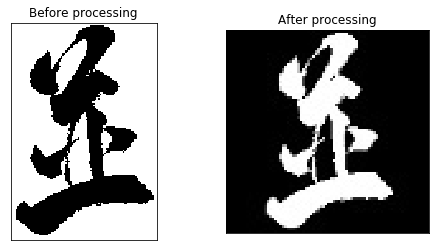

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4),
                         subplot_kw={'xticks':[], 'yticks':[]})


axes[0].imshow(plt.imread('images/18457.jpg'), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
draw_img(df.iloc[3,:].values, ax = axes[1])
axes[0].set_title('Before processing')
axes[1].set_title('After processing')

fig.show()

Then I add style(style of the image) and ID (filename of the image) to the dataframe.

In [21]:
#! pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12074 sha256=0c486cbfb1846a69a7689e1e56e9571d9b02f64a0eb2683a10adc8bf515078ad
  Stored in directory: /home/jovyan/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [10]:
from progressbar import ProgressBar
pbar = ProgressBar()

# Get labels of these images
for i in pbar(range(1,121)):
    ! grep 'alt="' projdata/{i}.html > tmp.txt
    ! grep -o -P '[0-9]+.gif" width="140" alt="[\p{Han}]*' tmp.txt\ 
    | sed 's/.gif" width="140" alt="/,/'\
    >> labels.csv

100% |########################################################################|


In [20]:
df['style'] = style
df['ID'] = ID
df['ID'] = df['ID'].astype(int)
styles = ['Semi-cursive','Clerical','Regular']
style_indices = range(3)
indices_to_styles_dict = dict(zip(style_indices, styles))
df['style'] = df['style'].map(indices_to_styles_dict)

labels = pd.read_csv ('labels.csv', names = ['ID','label'])
df = pd.merge(df,label, on = 'ID', how = 'left')
df.head()

0  1  2  3  4  5  6  7  8  9  ...  6393  6394  6395  6396  6397  6398  \
0  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

   6399         style     ID  label  
0     0  Semi-cursive  18454      並  
1     0  Semi-cursive  18455      並  
2     0  Semi-cursive  18456      並  
3     0  Semi-cursive  18457      並  
4     0  Semi-cursive  25369      一  

[5 rows x 6403 columns]

In [21]:
df.to_csv('Chinese_Calligraphy.csv', index = False)

### Summary of the dataset

In [3]:
df_count = df.groupby('style').count()

In [11]:
print('number of characters in dataset:', len(df))
print('number of Clerical characters in dataset:', df_count.iloc[0,0])
print('number of Regular characters in dataset:', df_count.iloc[1,0])
print('number of Semi-cursive characters in dataset:', df_count.iloc[2,0])
print('image width in pixels: 80\nimage height in pixels: 80')

number of characters in dataset: 5982
number of Clerical characters in dataset: 2000
number of Regular characters in dataset: 1991
number of Semi-cursive characters in dataset: 1991
image width in pixels: 80
image height in pixels: 80


## Data Visualization

I subset the dataframe based on styles and remove style,ID and label columns to get three new dataframe X1, X2 and X3.

In [3]:
X1 = df[df['style']=='Semi-cursive'].iloc[:,0:6400]
X2 = df[df['style']=='Clerical'].iloc[:,0:6400]
X3 = df[df['style']=='Regular'].iloc[:,0:6400]

X = df.iloc[:,0:6400]

Let's draw some images of each style to have a glimpse at the dataset. We can see that the strokes of regular scripts are more flat than that of the other two styles. Moreover, clerical scripts have relatively uniform thickness.  

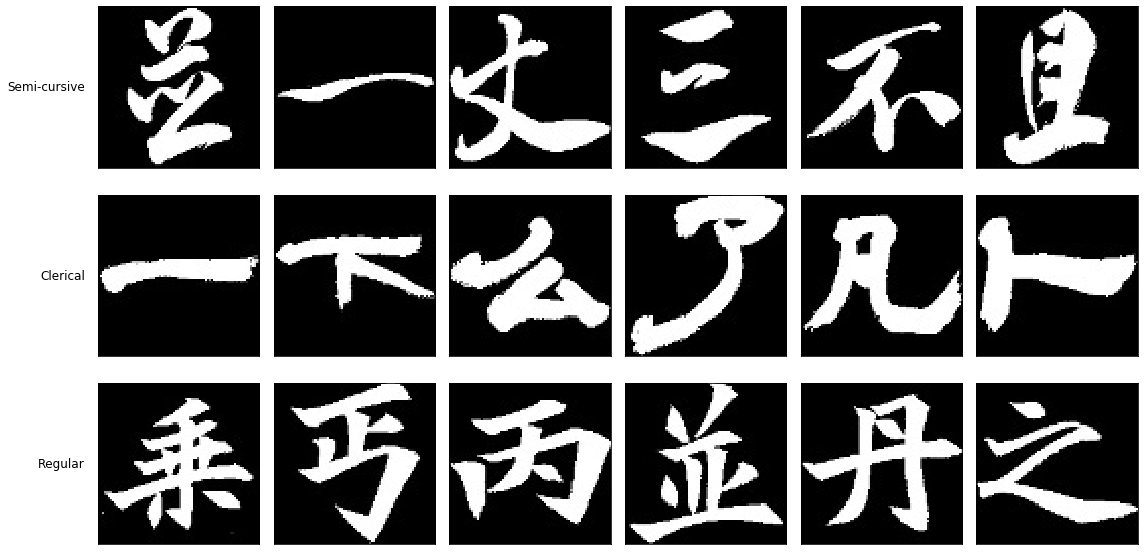

In [4]:
from matplotlib.transforms import offset_copy
pad = 5
fig, axes = plt.subplots(3, 6, figsize=(16, 8),
                         subplot_kw={'xticks':[], 'yticks':[]})

for i in range(6):
    draw_img(X1.iloc[i*6,:].values,ax = axes[0,i])
    
for i in range(6):
    draw_img(X2.iloc[i*6,:].values,ax = axes[1,i])
    
for i in range(6):
    draw_img(X3.iloc[i*6,:].values,ax = axes[2,i])
    
rows = ['Semi-cursive','Clerical','Regular']
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
fig.tight_layout()


### Draw Character images on the same plot

Chinese characters are sometimes called "square characters", because Chinese people usually write on papers with squares to have beautiful handwriting. However, are Chinese characters really "square characters"? In other words, can we get a filled square if we draw many Chinese Characters on the same plot? 

According the plot above, it seems that there are no strokes at the corner of the square. It is not very clear whether or not we can got a filled square by drawing many characters on the same plot.

I draw samples of different sizes from the dataset, plot each sample on one graph and analyze the changes of resulting graphs as the sample size increases.

To my surprise, most parts of the aquare is filled by white colors even with a small number of images (n = 20).  When the sample size is 200, only a small part of upper left and upper right corners are not filled. Is seems that there are less strokes in the upper left corner. Since the dataset only contains approximately 6000 images, it may not represent the true distribution very well. 

In [5]:
import numpy as np

def sample_X(df, size):
    """
    Draw a sample from a dataframe
    """
    
    from numpy.random import choice
    rng = np.random.default_rng()
    indx = rng.choice(len(df),size,replace = False)
    
    return df.iloc[indx]

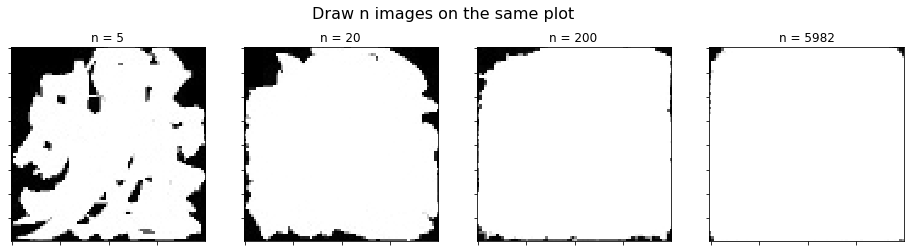

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

n = [5,20,200,len(X)]
for i in range(4):
    draw_img(sample_X(X,n[i]).max().values,ax = axes[i])

fig.suptitle('Draw n images on the same plot', fontsize=16)
cols = ['n = '+str(n[i]) for i in range(4)]

for ax, col in zip(axes, cols):
    ax.set_title(col)


### Compare with characters in other languages

Some people may argue that the strokes of these characters are very thick and thus the square can be easily filled with a small number of characters. To address that problem and also compare Chinese characters with characters in other languages, I ramdomly choose 90 Chinese characters, 90 Japanese characters(Hiragana and Katakana) and 90 Korean Characters(Hangul). Then I draw them on three plots using similar fonts. I choose 90 characters in each language because there are only 142 Hiragana and Katakana. This might not be a very good comparison, but I just want to get a rough idea about the different shapes of characters in different languages.

We can see that the plot of Chinese characters has the smallest white regions.

<img src="https://1.bp.blogspot.com/-T4fNr8gxd-U/XuM5Hn_3juI/AAAAAAAAAQs/PnDdCnAaxt47b-VxbnfgJEaJKwP4yhh-gCLcBGAsYHQ/s1600/compare%2Bcharacters.jpg" style="width: 800px;" align="center">

The code that generates the plot above is modified from https://www.zhihu.com/question/394175264/answer/1222055745

### Heatmap

In previous parts, I analyze the shape of Chinese characters. In this part, I aim to analyze the structure and stroke distribution of different styles.

I draw all the image of the same style on the same plot and use heatmap to visualize the stroke density in different regions.

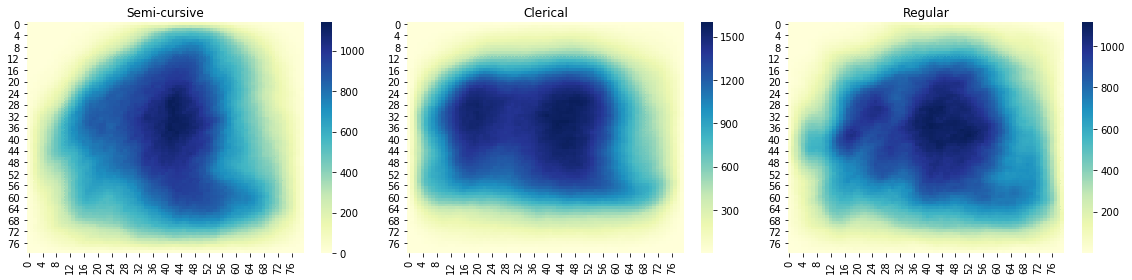

In [7]:
total1 = X1.sum(axis = 0)/255
total2 = X2.sum(axis = 0)/255
total3 = X3.sum(axis = 0)/255

import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.heatmap(total1.values.reshape(80,80), cmap = "YlGnBu",ax = axes[0])
sns.heatmap(total2.values.reshape(80,80), cmap = "YlGnBu",ax = axes[1])
sns.heatmap(total3.values.reshape(80,80), cmap = "YlGnBu",ax = axes[2])

cols = ['Semi-cursive','Clerical','Regular']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()

We can observe that each heatmap can be divided into two parts: an outer(yellow) part and an inner(blue) part. This  shows that most strokes are in the inner part.

Moreover, the shapes of the blue parts of different styles are very different. For example, blue part of clerical scripts is a rectangle while the blue part of semi-cursive scripts is like a disk. 

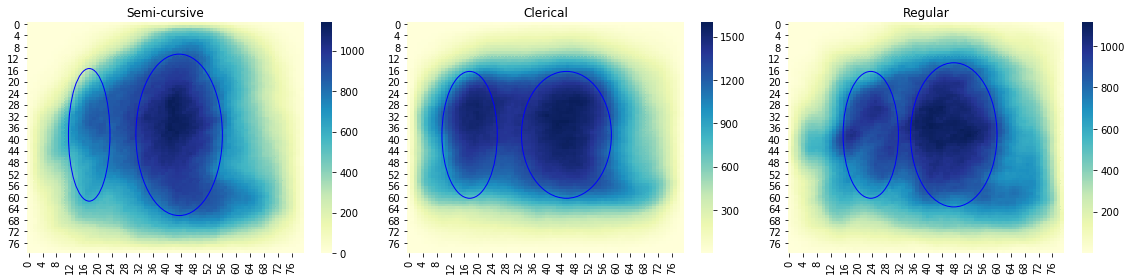

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.heatmap(total1.values.reshape(80,80), cmap = "YlGnBu",ax = axes[0])
sns.heatmap(total2.values.reshape(80,80), cmap = "YlGnBu",ax = axes[1])
sns.heatmap(total3.values.reshape(80,80), cmap = "YlGnBu",ax = axes[2])

from matplotlib.patches import Arc
from matplotlib.patches import Ellipse

Ellipse1 = Ellipse((18,39), 12, 46, angle=0, color = 'Blue', fill = False)
Ellipse2 = Ellipse((44,39), 25, 56, angle=0, color = 'Blue', fill = False)
axes[0].add_patch(Ellipse1)
axes[0].add_patch(Ellipse2)

Ellipse1 = Ellipse((18,39), 16, 44, angle=0, color = 'Blue', fill = False)
Ellipse2 = Ellipse((46,39), 26, 44, angle=0, color = 'Blue', fill = False)
axes[1].add_patch(Ellipse1)
axes[1].add_patch(Ellipse2)

Ellipse1 = Ellipse((24,39), 16, 44, angle=0, color = 'Blue', fill = False)
Ellipse2 = Ellipse((48,39), 25, 50, angle=0, color = 'Blue', fill = False)
axes[2].add_patch(Ellipse1)
axes[2].add_patch(Ellipse2)

cols = ['Semi-cursive','Clerical','Regular']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()

If we focus on the darkest blue part, we can observe that the darkest blue regions of all three graphs consist of two components, which I marked with blue ellipses. Chinese characters composed of  a left part and a right part are said to have "Left to Right" structures. More information about common structures of Chinese characters can be found [here](https://www.archchinese.com/arch_character_structure.html).

These heatmaps indicate that most of chinese characters have Left to Right structures. Furthermore, the left and right components of clerical scripts are of the same length. However, the right components of regular and semi-cursive scripts are slightly longer that the left components. 

The following is an interactive function that samples images from the dataset and plot the heapmap of them. You can see the changes of the heamap when the number of images changes.

In [8]:
rng = np.random.default_rng()
indx = rng.choice(len(X),len(X),replace = False)
shuffle = X.iloc[indx]

from ipywidgets import interact

def interactive_plot(sample_size=(1, 5000, 100)):
    total = shuffle.iloc[0:sample_size,:].sum(axis = 0)/255
    ax = sns.heatmap(total.values.reshape(80,80), cmap = "YlGnBu")

interact(interactive_plot);

interactive(children=(IntSlider(value=2401, description='sample_size', max=5000, min=1, step=100), Output()), …

## PCA

In this section, I apply PCA on the dataset to do dimension reduction. 

### 2D visualization

Let's first visualize the PCA transformed data in a two dimensional space.

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [11]:
principalDf['style'] = df['style']
principalDf['ID'] = df['ID']
principalDf['label'] = df['label']
principalDf.head()

principal component 1  principal component 2         style     ID label
0           -2984.030225            2126.421271  Semi-cursive  18454     並
1           -2037.622104             650.882559  Semi-cursive  18455     並
2           -1550.734065            2107.065657  Semi-cursive  18456     並
3           -3468.786476            1582.021171  Semi-cursive  18457     並
4           -2258.890544           -3906.211958  Semi-cursive  25369     一

In [12]:
import altair as alt

alt.data_transformers.disable_max_rows()
source1 = principalDf

Chart1 = alt.Chart(source1, width = 300, height = 300).mark_circle(size=20).encode(
    x='principal component 1',
    y='principal component 2',
    color='style:N',
    tooltip=['style','ID','label']
).properties(title="All styles").interactive()

source2 = principalDf[principalDf['style']!= 'Regular']

Chart2 = alt.Chart(source2, width = 300, height = 300).mark_circle(size=20).encode(
    x='principal component 1',
    y='principal component 2',
    color='style:N',
    tooltip=['style', 'ID','label']
).properties(title="Clerical and Semi-cursive")

source3 = principalDf[principalDf['style']!= 'Clerical']

Chart3 = alt.Chart(source3, width = 300, height = 300).mark_circle(size=20).encode(
    x='principal component 1',
    y='principal component 2',
    color='style:N',
    tooltip=['style', 'ID','label']
).properties(title="Regular and Semi-cursive")

source4 = principalDf[principalDf['style']!= 'Semi-cursive']
Chart4 = alt.Chart(source4, width = 300, height = 300).mark_circle(size=20).encode(
    x='principal component 1',
    y='principal component 2',
    color='style:N',
    tooltip=['style', 'ID','label']
).properties(title="Clerical and Regular")

(Chart1 & Chart2) | (Chart3 & Chart4)

alt.HConcatChart(...)

We observe that blue circles are separated from red and yellow circles. The reason for the separation might be that strokes of clerical scripts have unique shapes. However, the distribution of red and yellow circles looks very similar. 

### Basis image

We can see that most basis are noisy components that have low interpretability. It seems that some basis images are representing structures of Chinese characters. For example, the first base seems to represent Left to Right structure and the fifth structure represents the Full Surround structure.

In [13]:
pca = PCA().fit(X)

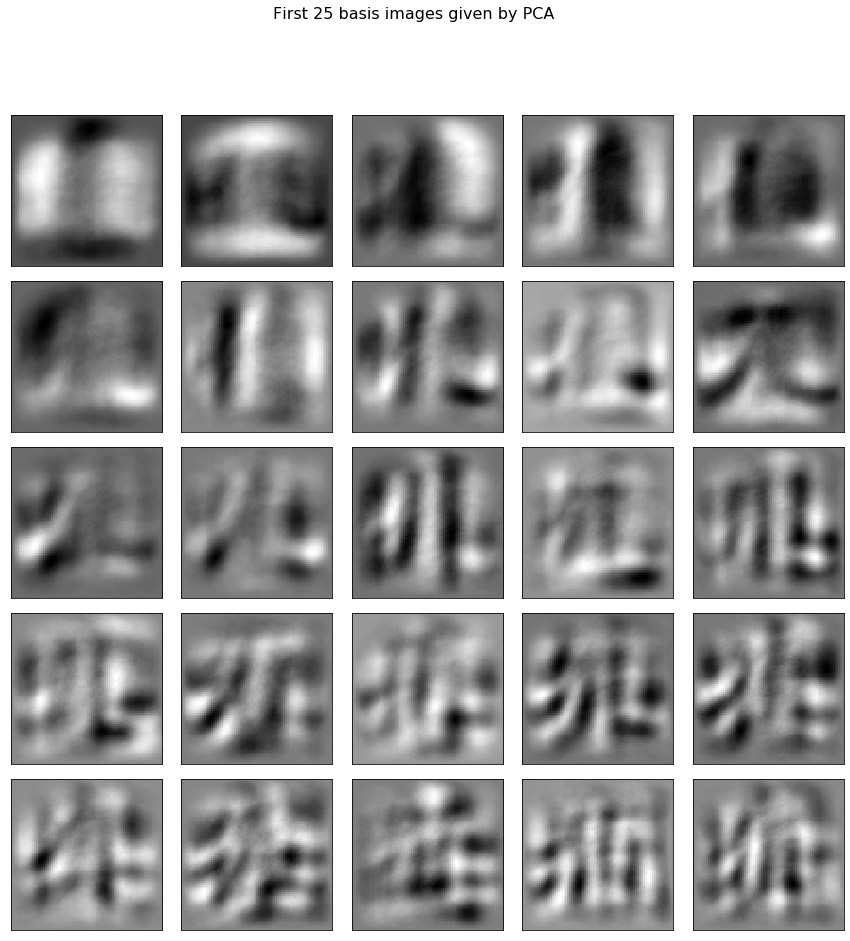

In [14]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('First 25 basis images given by PCA', fontsize=16)
for i, ax in enumerate(axes.flat):
    draw_img(pca.components_[i], ax = ax)

### Cumulative variance explained 

To determine how many principal components are needed, I draw the cumulative explained variance ratio plot. It indicates that about 200 principal components are needed to capture 80 percent variance.

In [15]:
explained_variance = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)
a = pd.DataFrame({'cum_var': explained_variance, 'num': range(len(explained_variance))})

source = a

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['num'], empty='none')

# The basic line
line = alt.Chart(a[0:2000]).mark_line(interpolate='basis', color='red').encode(
    alt.X('num:Q',
        scale=alt.Scale(domain=(0, 2000)),
        axis=alt.Axis(title='Principal Component')
    ),
    alt.Y('cum_var:Q',
        scale=alt.Scale(0, 1),
        axis=alt.Axis(title='Cumulative PVE')
    ),
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(source).mark_point().encode(
    x='num:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'cum_var:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(source).mark_rule(strokeDash=[1,1],color='gray').encode(
    x='num:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)

alt.LayerChart(...)

### Reconstructed image

In [16]:
pca_200 = PCA(n_components=200)
principalComponents = pca_200.fit_transform(X)
principalDf_200 = pd.DataFrame(data = principalComponents, 
                               columns = ['principal component '+str(i) for i in range(1,201)])

In [17]:
principalDf_200.head()

principal component 1  principal component 2  principal component 3  \
0           -2984.030392            2126.425499            -271.429048   
1           -2037.623994             650.872306            -295.339537   
2           -1550.735459            2107.059504            -278.051183   
3           -3468.786312            1582.019643            -773.627683   
4           -2258.890792           -3906.207273             546.257294   

   principal component 4  principal component 5  principal component 6  \
0            -555.187904            -638.075826             591.528833   
1            -191.445021           -1320.793744            1351.261452   
2            -723.991278           -1271.272208             297.225207   
3            -720.549851            -338.683190             685.560133   
4             603.379607            1394.195375           -2156.879656   

   principal component 7  principal component 8  principal component 9  \
0            -862.131268             483.103243            1067.565016   
1            -531.332184           -1164.619790             807.253302   
2           -1807.674571            1233.296480            1749.179026   
3            -142.928413             -97.317564             773.792810   
4            -338.965216            -720.430074             899.449486   

   principal component 10  ...  principal component 191  \
0              357.532601  ...               -61.681707   
1              -78.553818  ...               -21.328733   
2              197.464967  ...                32.838473   
3              -71.438326  ...               296.971134   
4             1111.094776  ...               -35.449185   

   principal component 192  principal component 193  principal component 194  \
0               212.611726               160.207799              -311.194868   
1              -277.965503               159.805937              -166.283397   
2              -422.594121              -139.884276               234.926417   
3               117.866245                50.921520               315.168900   
4               205.058406               159.712618                85.196194   

   principal component 195  principal component 196  principal component 197  \
0              -129.494758               120.482542               -70.260000   
1                19.095207               170.558202               -43.789165   
2              -314.703862               276.169148               108.790536   
3               -66.847373                22.629275               -39.832447   
4               -35.314379                65.228955               194.218050   

   principal component 198  principal component 199  principal component 200  
0               -55.195213               234.368473                 9.044719  
1              -118.668580                63.772817              -418.959616  
2                 3.098737               168.743778                78.074969  
3              -418.092821               273.975909               164.910172  
4               -37.006654               -76.367928              -104.768889  

[5 rows x 200 columns]

In [18]:
components = pca_200.transform(X)
X_hat_PCA_200 = pca_200.inverse_transform(components)

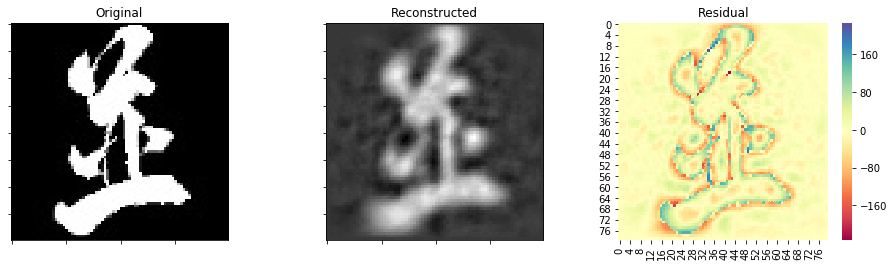

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

error_PCA = X.iloc[3,:]-X_hat_PCA_200[3]

draw_img(X.iloc[3,:].values,ax = axes[0])
draw_img(X_hat_PCA_200[3], ax = axes[1])
sns.heatmap(error_PCA.values.reshape(80,80), cmap = 'Spectral', ax = axes[2])

axes[0].set_title('Original')
axes[1].set_title('Reconstructed')
axes[2].set_title('Residual')

plt.show()

## NMF

In this section, I will perform NMF with different number of components to the data. NMF is different from PCA in the way that PCA finds a subspace which conserves the variance of the data while NMF finds nonnegative features. Moreover, NMF learns a part-based representation of the data. Each Chinese character is composed of several strokes. I want to check if NMF can learn those strokes from the data.

### NMF with 3 basis
I first apply NMF with 3 components. We can see that these basis images are trying capture the common shapes of characters in this dataset.

In [20]:
from sklearn.decomposition import NMF

In [21]:
model = NMF(n_components=3, init='nndsvd', random_state=0)
W3 = model.fit_transform(X)
H3 = model.components_

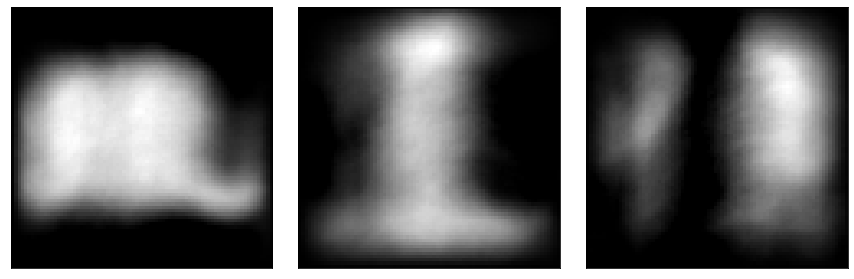

In [22]:
fig, axes = plt.subplots(1,3, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    draw_img(H3[i],ax = ax)

### NMF with 28 basis

It turns out that when the number of components is relatively large (for example, 200 components), the basis images given by NMF are just white dots in different positions. I find that NMF picks individual stroke or radical as basis when the number of components is about 28. For intance, the second plot in the first row looks like "丨", the second plot in the second row is like "刂" and the third plot in the second row seems to be  "亻".

In [23]:
model = NMF(n_components=28, init='nndsvd', random_state=0)
W28 = model.fit_transform(X)
H28 = model.components_

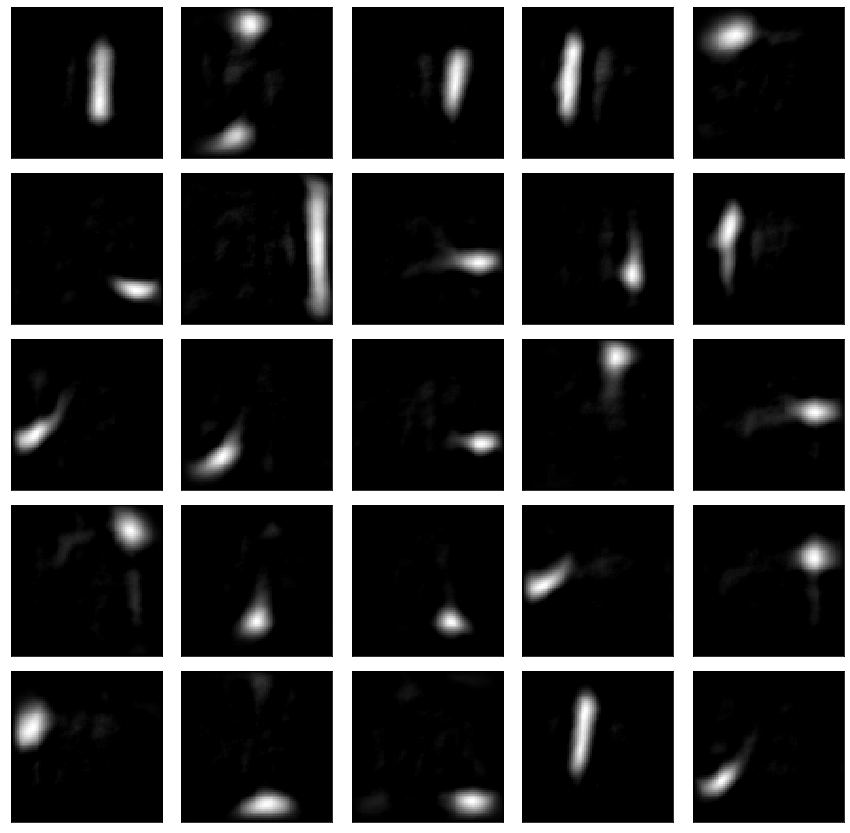

In [24]:
fig, axes = plt.subplots(5,5, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    draw_img(H28[i],ax = ax)

### Compare with PCA

In this section, I apply NMF with 200 components and compare the reconstructed image with the image recontructed by PCA with the same number of components.

In [25]:
model = NMF(n_components=200, init='nndsvd', random_state=0)
W200 = model.fit_transform(X)
H200 = model.components_

In [26]:
X_hat = W200@H200

In [27]:
NMFDf_200 = pd.DataFrame(data = W200, columns = ['component '+str(i) for i in range(1,201)])

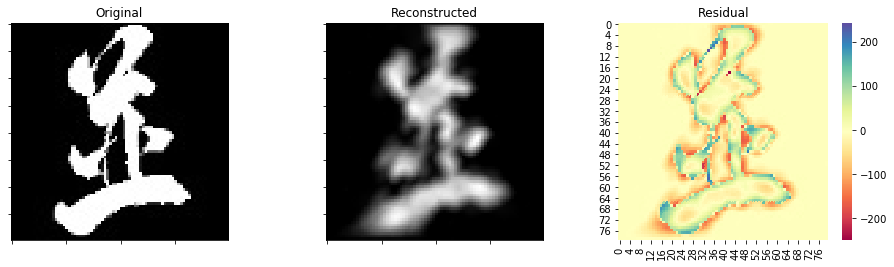

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

error_NMF = X.iloc[3,:]-X_hat[3]

draw_img(X.iloc[3,:].values,ax = axes[0])
draw_img(X_hat[3], ax = axes[1])
sns.heatmap(error_NMF.values.reshape(80,80), cmap = 'Spectral', ax = axes[2])

axes[0].set_title('Original')
axes[1].set_title('Reconstructed')
axes[2].set_title('Residual')

plt.show()

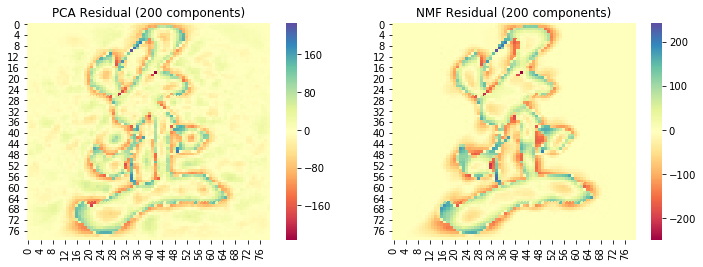

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(error_PCA.values.reshape(80,80), cmap = 'Spectral', ax = axes[0])
sns.heatmap(error_NMF.values.reshape(80,80), cmap = 'Spectral', ax = axes[1])

axes[0].set_title('PCA Residual (200 components)')
axes[1].set_title('NMF Residual (200 components)')

plt.show()

We can see that the image reconstructed by PCA nearly retain the shape of each stroke though there are small errors over the whole images. On the contrary, the reconstructed images of NMF nearly has no error for the black background part while it has higher error at the edges of strokes.  Moreover, the shape of some strokes seem to be "distorted" after the reconstruction by NMF. Since the shape of strokes is an important feature in style analysis, it might not be a good idea to use NMF for dimension reduction when analyzing styles of Chinese calligraphy images.

## Clustering

In this section, I apply Kmeans clustering to the PCA transformed data.

In [30]:
rng = np.random.default_rng()
shuffle_idx = rng.choice(len(X),len(X),replace = False)
df_shuffle= df.iloc[shuffle_idx].copy()

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
score = []
k_cluster = np.arange(2,11)
for i in k_cluster:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(principalDf_200.iloc[shuffle_idx])
    score.append(silhouette_score(principalDf_200.iloc[shuffle_idx], kmeans.labels_))
    

In [32]:
k_cluster[np.argmax(score)]

2

In [33]:
# K = 2
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(principalDf_200.iloc[shuffle_idx])

df_shuffle['cluster'] = kmeans_2.labels_

In [34]:
import altair as alt

alt.data_transformers.disable_max_rows()

source1 = df_shuffle.iloc[:,[6400,6403]]
cluster1 = alt.Chart(source1).mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).properties(
    width=alt.Step(100)  # controls width of bar.
).encode(
    x='cluster:O',
    y='count():Q',
    color='style:N'
).properties(title="K = 2")

cluster1

alt.Chart(...)

In [35]:
# K = 3
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(principalDf_200.iloc[shuffle_idx])
df_shuffle = df.iloc[shuffle_idx].copy()
df_shuffle['cluster'] = kmeans_3.labels_

In [38]:
source2 = df_shuffle.iloc[:,[6400,6403]]
cluster2 = alt.Chart(source2).mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).properties(
    width=alt.Step(80)  # controls width of bar.
).encode(
    x='cluster:O',
    y='count():Q',
    color='style:N'
).properties(title="K = 3")

cluster2

alt.Chart(...)

We can see that 
- We get the highest silhouette score when k = 2.
- Clerical scripts are clustered into groups with small number of other two styles. It shows that clerical script is relatively easy to separated from the other styles by Kmeans clustering.
- There are not clusters contain mainly regular script or semi-cursive scripts. It seems that Kmeans clustering is not a good method to recongnize regular and semi-cursive script.

## Possible future work

### More clustering methods

I only applied Kmeans clustering and did simple analysis in the clustering part because of the time constrain. I will try different clustering methods and analyze the resulting clusters if I have more time. 

### Damaged images

I noticed that there are few damaged images in the dataset. For example, the following one.

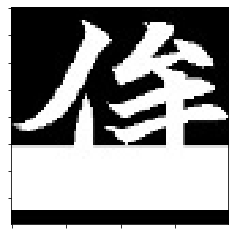

In [37]:
idx = df[df['ID']==14995].index[0]
draw_img(X.iloc[idx,:].values)

The white rectangle in this image is clearly not a part of the character. I did not do any things to images like this because I have not thought of a clever way to find such images in the dataset and the number of such images is very small. Actually if we analyze ancient Chinese calligraphy works, it is very possible that some characters are damaged. So I am also wondering if there is a good way to restore these damaged images.

### Single character image v.s. full page image

In this project I use single character images to analyze characters of different styles in Chinese calligraphy. However, it might be better to start with full page Chinese calligraphy works since the relative size and postition of each characters could be useful features.
<img src="https://1.bp.blogspot.com/-PUoajPOR-1U/Xuau_byzIYI/AAAAAAAAAQ4/NFT0fqBFYYQrkJ8TSgKcTRIkgTCM5pXlQCLcBGAsYHQ/s1600/fullpage.jpg" style="width: 200px;" align="center">
